>>> TESTING VOLATILITY EXPANSION HYPOTHESIS FOR NVDA <<<

--- RESULTS (2020-01-01 to 2025-05-05) ---
Buy & Hold Return:   1817.23%
Trend Only (ADX>25): 0.00%
Chop Only (ADX<25):  1817.23%


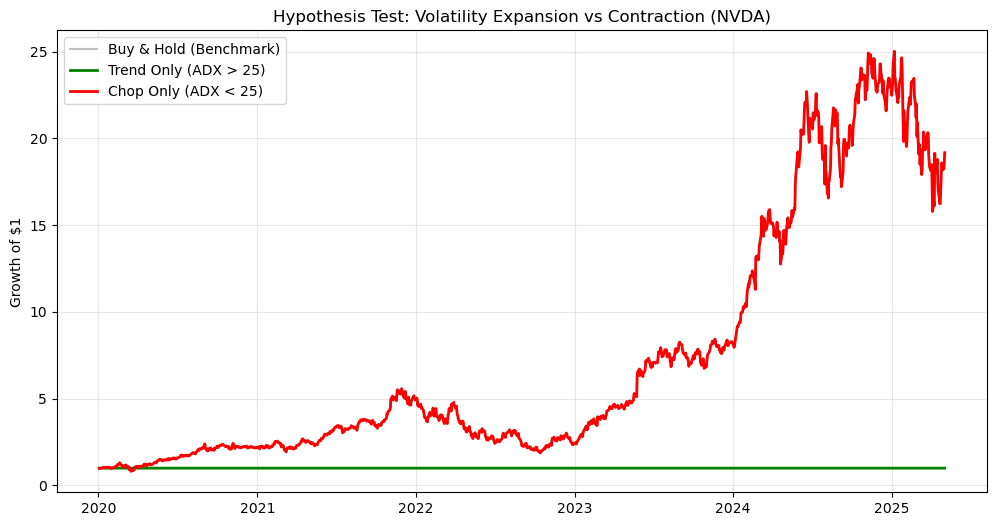


>>> VERDICT: HYPOTHESIS REJECTED. Chop Regime contributes significantly. <<<
Recommendation: Refine Accumulation Logic (Mean Reversion).


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
TICKER = "NVDA"
START_DATE = "2020-01-01"
END_DATE = "2025-05-05"
ADX_THRESHOLD = 25
ADX_WINDOW = 14

def calculate_adx(df, window=14):
    """
    Calculates the Average Directional Index (ADX).
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # 1. True Range
    tr = np.maximum(high - low, 
           np.maximum(abs(high - close.shift(1)), 
                      abs(low - close.shift(1))))
    
    # 2. Directional Movement
    dm_plus = np.where((high - high.shift(1)) > (low.shift(1) - low), 
                       np.maximum(high - high.shift(1), 0), 0)
    dm_minus = np.where((low.shift(1) - low) > (high - high.shift(1)), 
                        np.maximum(low.shift(1) - low, 0), 0)
    
    # 3. Smoothed TR and DM (Wilder's Smoothing)
    # Using simple rolling mean for approximation in this test script
    # For production, use exponential moving average or Wilder's specific smoothing
    tr_s = tr.rolling(window).sum()
    dm_plus_s = pd.Series(dm_plus).rolling(window).sum()
    dm_minus_s = pd.Series(dm_minus).rolling(window).sum()
    
    # 4. DI+ and DI-
    di_plus = 100 * (dm_plus_s / tr_s)
    di_minus = 100 * (dm_minus_s / tr_s)
    
    # 5. DX and ADX
    dx = 100 * abs(di_plus - di_minus) / (di_plus + di_minus)
    adx = dx.rolling(window).mean()
    
    return adx.fillna(0)

def run_hypothesis_test():
    print(f">>> TESTING VOLATILITY EXPANSION HYPOTHESIS FOR {TICKER} <<<")
    
    # 1. Data Fetch
    data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
    
    # Handle MultiIndex columns (Fix for yfinance > 0.2)
    if isinstance(data.columns, pd.MultiIndex):
        try:
            # If ticker is in level 1, drop it to get simple OHLC columns
            if TICKER in data.columns.get_level_values(1):
                data = data.xs(TICKER, axis=1, level=1)
            # Fallback: Just drop the second level if it exists
            elif data.columns.nlevels > 1:
                data.columns = data.columns.droplevel(1)
        except Exception:
            pass

    # Ensure 'Close' column exists
    if 'Close' not in data.columns and 'Adj Close' in data.columns:
        data['Close'] = data['Adj Close']
        
    # Ensure High/Low exist for ADX
    if 'High' not in data.columns or 'Low' not in data.columns:
        print("Warning: High/Low data missing. ADX calculation may fail.")

    # 2. Feature Engineering
    data['returns'] = data['Close'].pct_change()
    data['adx'] = calculate_adx(data, window=ADX_WINDOW)
    
    # 3. Segmentation Logic
    # Strategy A: "Chop" (Accumulation) - Hold ONLY when ADX < 25
    # Strategy B: "Trend" (Expansion) - Hold ONLY when ADX > 25
    
    data['signal_chop'] = np.where(data['adx'] < ADX_THRESHOLD, 1.0, 0.0)
    data['signal_trend'] = np.where(data['adx'] > ADX_THRESHOLD, 1.0, 0.0)
    
    # Lag signal by 1 day to avoid look-ahead bias (trade on yesterday's ADX)
    data['signal_chop'] = data['signal_chop'].shift(1)
    data['signal_trend'] = data['signal_trend'].shift(1)
    
    # 4. PnL Calculation
    data['pnl_chop'] = data['returns'] * data['signal_chop']
    data['pnl_trend'] = data['returns'] * data['signal_trend']
    
    # Cumulative Returns
    data['cum_chop'] = (1 + data['pnl_chop']).cumprod()
    data['cum_trend'] = (1 + data['pnl_trend']).cumprod()
    data['cum_hold'] = (1 + data['returns']).cumprod() # Benchmark
    
    # 5. Results
    final_chop = data['cum_chop'].iloc[-1] - 1
    final_trend = data['cum_trend'].iloc[-1] - 1
    final_hold = data['cum_hold'].iloc[-1] - 1
    
    print(f"\n--- RESULTS ({START_DATE} to {END_DATE}) ---")
    print(f"Buy & Hold Return:   {final_hold:.2%}")
    print(f"Trend Only (ADX>25): {final_trend:.2%}")
    print(f"Chop Only (ADX<25):  {final_chop:.2%}")
    
    # 6. Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['cum_hold'], label='Buy & Hold (Benchmark)', color='gray', alpha=0.5)
    plt.plot(data.index, data['cum_trend'], label='Trend Only (ADX > 25)', color='green', linewidth=2)
    plt.plot(data.index, data['cum_chop'], label='Chop Only (ADX < 25)', color='red', linewidth=2)
    
    plt.title(f"Hypothesis Test: Volatility Expansion vs Contraction ({TICKER})")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 7. Verdict
    if final_chop < 0:
        print("\n>>> VERDICT: HYPOTHESIS CONFIRMED. Chop Regime is Negative EV. <<<")
        print("Recommendation: DELETE Accumulation Agent for this asset.")
    elif final_chop < final_hold * 0.1:
        print("\n>>> VERDICT: HYPOTHESIS SUPPORTED. Chop Regime is Dead Money. <<<")
        print("Recommendation: Replace Accumulation with Cash/Yield.")
    else:
        print("\n>>> VERDICT: HYPOTHESIS REJECTED. Chop Regime contributes significantly. <<<")
        print("Recommendation: Refine Accumulation Logic (Mean Reversion).")

if __name__ == "__main__":
    run_hypothesis_test()


>>> STARTING HYPERPARAMETER OPTIMIZATION FOR NVDA <<<
>>> OPTIMIZATION MODE: SMART GRID (Train once per Window, Backtest many) <<<

[Training Phase] Compiling Agents for Window Size: 40...
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2015-01-01 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2018-10-01 to 2019-01-01)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2020-01-01 to 2020-05-01)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2022-01-01 to 2022-12-31)



2 Failed downloads:
['^VIX', 'SHY']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


[Inference Phase] Testing 80 threshold combinations...
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)



1 Failed download:
['SHY']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')

1 Failed download:
['SHY']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


  >>> NEW BEST: 193.23% | Win:40 | {'ADX_THRESHOLD': 15, 'JUMP_THRESHOLD': 2.0, 'ACCUM_SMA_WINDOW': 50}
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 t


2 Failed downloads:
['^VIX', 'SHY']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


[Inference Phase] Testing 80 threshold combinations...
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2021-12-31 to 2023-12-31)
Fetching data for: ['SHY', '^VIX', 


1 Failed download:
['^VIX']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


=== TRAINING COMPLETE ===

=== 2. RUNNING BACKTEST (2024-02-05 to 2025-05-05) ===
Fetching data for: ['SHY', '^VIX', 'NVDA'] (2023-02-05 to 2025-05-05)



1 Failed download:
['^VIX']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Date         | Regime       | Active Agent | Raw Act  | Scale Act  | Portfolio  | Bench      | Daily Alpha
------------------------------------------------------------------------------------------------------------------------
2024-02-20   | TREND        | trend        | 1.00     | 1.00       | 104926     | 104976     |        0 bps
2024-03-19   | CRISIS       | crisis       | 1.00     | 1.00       | 135066     | 135130     |        0 bps
2024-04-17   | ACCUMULATION | accumulation | 0.00     | 0.00       | 127782     | 127024     |      387 bps
2024-05-15   | ACCUMULATION | accumulation | 1.00     | 1.00       | 158611     | 143039     |        0 bps
2024-06-13   | TREND        | trend        | 1.00     | 1.00       | 217260     | 195929     |        0 bps
2024-07-15   | ACCUMULATION | accumulation | 1.00     | 1.00       | 215299     | 194160     |        0 bps
2024-08-12   | CRISIS       | crisis       | 1.00     | 1.00       | 173502     | 164804     |        0 bps
2024-09-10   | B

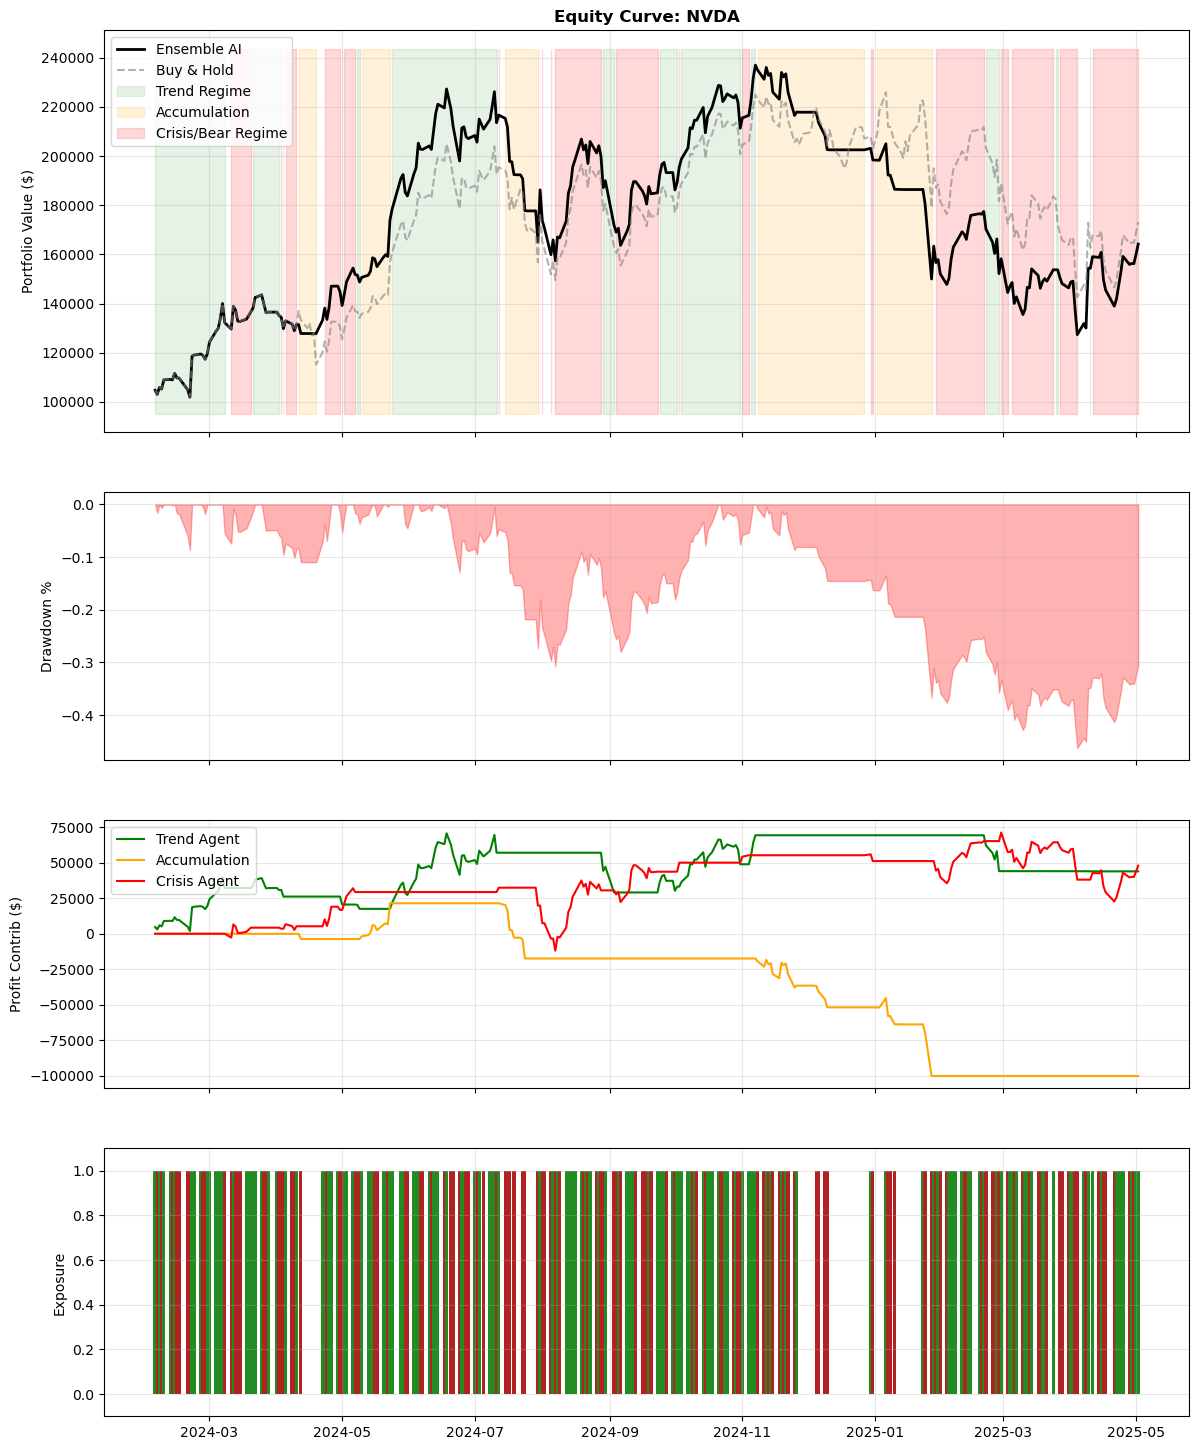

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
DEFAULT_CONFIG = {
    # Assets
    "TICKERS": ["SPY", "IWM", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # Dates
    "TRAIN_START": "2015-01-01",
    "TRAIN_END": "2023-12-31",
    "TEST_START": "2024-01-02",
    "TEST_END": "2025-05-05",
    
    # Crisis Training Periods
    "CRISIS_PERIODS": [
        ("2018-10-01", "2019-01-01"), # Volmageddon
        ("2020-01-01", "2020-05-01"), # COVID
        ("2022-01-01", "2022-12-31"), # Bear
    ],
    
    # Hyperparameters (Optimizable)
    "WINDOW_SIZE": 60, 
    "ADX_THRESHOLD": 25,
    "JUMP_THRESHOLD": 3.5, 
    "ACCUM_SMA_WINDOW": 50,
    "TARGET_VOL": 0.40,
    
    # Fixed Params
    "BB_STD": 2.0,
    "LEARNING_RATE": 3e-4,
    "BATCH_SIZE": 64,
    "TRAINING_STEPS": 50000, 
    "INITIAL_BALANCE": 100000,
    "FEES": 0.0005,
    "BORROW_RATE": 0.0002, 
    "ACTION_SCALER": 5.0,
    "MAX_LEVERAGE": 1.0, 
    "USE_VOL_TARGETING": True,
    "SMA_TREND_FILTER": True,
    "LONG_ONLY": False 
}

# --- DATA PROCESSOR ---
class DataProcessor:
    def __init__(self, tickers, config):
        self.tickers = list(set(tickers))
        self.config = config
        
    def download(self, start, end):
        try:
            if self.config['TARGET_ASSET'] not in self.tickers:
                self.tickers.append(self.config['TARGET_ASSET'])
                
            print(f"Fetching data for: {self.tickers} ({start} to {end})")
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]: data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]: data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]: data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): 
                data = data.to_frame()
                if self.config['TARGET_ASSET'] not in data.columns:
                    data.columns = [self.config['TARGET_ASSET']]
            
            # Need Volume for Volume Alpha
            ohlc = yf.download(self.config['TARGET_ASSET'], start=start, end=end, progress=False)
            
            # Merge Volume into main data if not present (simple check)
            if 'Volume' not in data.columns:
                data['Volume'] = ohlc['Volume']
                
            return data, ohlc
        except Exception as e:
            print(f"Data Download Error: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def calculate_lee_mykland(self, df, window=20):
        log_ret = np.log(df / df.shift(1))
        abs_ret = np.abs(log_ret)
        bv_terms = abs_ret * abs_ret.shift(1)
        local_vol = np.sqrt((np.pi / 2) * bv_terms.rolling(window=window).mean())
        l_stat = log_ret / (local_vol + 1e-9)
        return l_stat.fillna(0)

    def calculate_vw_macd(self, df, fast=12, slow=26, signal=9):
        # Dollar Volume
        # Handle case where df is Series or DataFrame
        try:
            close = df['Close']
        except KeyError:
            # If 'Close' is missing, it might be the Series itself or differently named
            close = df.iloc[:, 0] if isinstance(df, pd.DataFrame) else df

        try:
            volume = df['Volume']
        except KeyError:
            volume = 1.0 # Default if volume missing

        vw_price = close * volume
        ema_fast = vw_price.ewm(span=fast, adjust=False).mean()
        ema_slow = vw_price.ewm(span=slow, adjust=False).mean()
        vw_macd_line = ema_fast - ema_slow
        vw_signal_line = vw_macd_line.ewm(span=signal, adjust=False).mean()
        vw_hist = vw_macd_line - vw_signal_line
        return vw_hist.fillna(0)

    def calculate_force_index(self, df, window=13):
        try:
            close = df['Close']
        except KeyError:
            close = df.iloc[:, 0] if isinstance(df, pd.DataFrame) else df
            
        try:
            volume = df['Volume']
        except KeyError:
            volume = 1.0

        raw_force = (close - close.shift(1)) * volume
        efi = raw_force.ewm(span=window, adjust=False).mean()
        return efi.fillna(0)

    def add_features(self, df, ohlc):
        target = self.config['TARGET_ASSET']
        if df.empty or target not in df.columns: return pd.DataFrame()
        
        df = df.copy()
        
        # Ensure Volume Exists (Handle MultiIndex or Missing)
        if 'Volume' not in df.columns:
             # Try to recover from ohlc
             try:
                 df['Volume'] = ohlc['Volume']
             except:
                 df['Volume'] = 1.0 # Fail safe (Avoid crash, but breaks volume logic)

        df['returns'] = df[target].pct_change()
        
        # --- VOLUME ALPHA INDICATORS (NEW V14) ---
        df['vw_macd_hist'] = self.calculate_vw_macd(df)
        df['efi_13'] = self.calculate_force_index(df)
        df['vol_avg_20'] = df['Volume'].rolling(window=20).mean()
        
        # JUMP DETECTION
        l_stat = self.calculate_lee_mykland(df[target], window=20)
        df['l_stat'] = l_stat
        
        # RSI 
        delta = df[target].diff()
        gain = (delta.where(delta > 0, 0)).fillna(0)
        loss = (-delta.where(delta < 0, 0)).fillna(0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # Trend
        high = ohlc['High']
        low = ohlc['Low']
        close = ohlc['Close']
        df['tr'] = np.maximum(high - low, np.maximum(abs(high - close.shift(1)), abs(low - close.shift(1))))
        df['dm_plus'] = np.where((high - high.shift(1)) > (low.shift(1) - low), np.maximum(high - high.shift(1), 0), 0)
        df['dm_minus'] = np.where((low.shift(1) - low) > (high - high.shift(1)), np.maximum(low.shift(1) - low, 0), 0)
        
        window = 14
        df['tr_s'] = df['tr'].rolling(window).mean()
        df['dp_s'] = df['dm_plus'].rolling(window).mean()
        df['dm_s'] = df['dm_minus'].rolling(window).mean()
        df['di_plus'] = 100 * (df['dp_s'] / df['tr_s'])
        df['di_minus'] = 100 * (df['dm_s'] / df['tr_s'])
        df['dx'] = 100 * abs(df['di_plus'] - df['di_minus']) / (df['di_plus'] + df['di_minus'])
        df['adx'] = df['dx'].rolling(window).mean()
        
        # Mean Reversion / Crisis
        sma = df[target].rolling(20).mean()
        std = df[target].rolling(20).std()
        df['bb_width'] = (std * 2 * 2) / sma
        df['pct_b'] = (df[target] - (sma - 2*std)) / (4*std)
        
        if '^VIX' in df.columns: df['vix_norm'] = (df['^VIX'] - 15) / 40
        else: df['vix_norm'] = 0
            
        sma200 = df[target].rolling(200).mean()
        df['dist_sma200'] = (df[target] - sma200) / sma200
        
        # --- DYNAMIC SMA GENERATION ---
        df['dist_sma50'] = (df[target] - df[target].rolling(50).mean()) / df[target].rolling(50).mean()
        df['dist_sma100'] = (df[target] - df[target].rolling(100).mean()) / df[target].rolling(100).mean()
        df['dist_sma150'] = (df[target] - df[target].rolling(150).mean()) / df[target].rolling(150).mean()
        df['dist_sma200'] = (df[target] - df[target].rolling(200).mean()) / df[target].rolling(200).mean()
        
        # Volatility
        df['realized_vol_20d'] = df['returns'].rolling(20).std() * np.sqrt(252)
        df['vol_percentile'] = df['realized_vol_20d'].rolling(252).rank(pct=True)
        
        return df.fillna(0)

    def get_data(self, start, end):
        df, ohlc = self.download(start, end)
        return self.add_features(df, ohlc)

    def get_crisis_data(self):
        dfs = []
        for s, e in self.config['CRISIS_PERIODS']:
            d, o = self.download(s, e)
            dfs.append(self.add_features(d, o))
        return pd.concat(dfs).reset_index(drop=True).fillna(0)

# --- ENVIRONMENT (ADDED RECOVERY REWARD) ---
class TradingEnv(gym.Env):
    def __init__(self, df, config, mode='trend'):
        super(TradingEnv, self).__init__()
        self.df = df
        self.config = config
        self.mode = mode 
        self.n_features = df.shape[1]
        self.window = config['WINDOW_SIZE']
        self.current_step = self.window
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window * self.n_features,), dtype=np.float32)
        
        self.data = df.values.astype(np.float32)
        self.cols = df.columns.tolist()
        self.idx_sma = self.cols.index('dist_sma200') if 'dist_sma200' in self.cols else -1
        self.idx_pct_b = self.cols.index('pct_b') if 'pct_b' in self.cols else -1
        
    def reset(self, seed=None, options=None):
        self.current_step = self.window
        return self._get_obs(), {}
    
    def _get_obs(self):
        return self.data[self.current_step-self.window : self.current_step].flatten()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, False, {}
            
        act = np.clip(action[0], -1, 1)
        ret = self.data[self.current_step, 0] 
        
        reward = 0
        if self.mode == 'trend':
            reward = act * ret * 100
            if self.idx_sma != -1:
                sma_dist = self.data[self.current_step, self.idx_sma]
                if sma_dist > 0 and act > 0.1: reward += 0.05 * act 
                elif sma_dist < 0 and act < -0.1: reward += 0.05 * abs(act)
                
        elif self.mode == 'accumulation': 
            reward = (act * ret * 100) 
            if act > 0.5: reward += 0.05 * act
            if act < 0: reward -= 0.1 * abs(act)

        elif self.mode == 'crisis':
            reward = (act * ret * 100)
            if ret < -0.01 and act < -0.1: reward *= 2.0 
            elif ret < -0.01 and act > 0.1: reward -= (act * 10.0) 
            
        elif self.mode == 'recovery': # NEW AGENT
            # Reward catching the V-Bottom (buying when others are fearful)
            reward = (act * ret * 100)
            if act > 0.5 and ret > 0.02: # Big buy on big up day
                reward *= 1.5 
            
        self.current_step += 1
        return self._get_obs(), reward, False, False, {}

# --- MANAGER ---
class EnsembleManager:
    def __init__(self, config):
        self.config = config
        self.dp = DataProcessor(config['TICKERS'], config)
        self.agents = {}
        self.envs = {}
        
    def train_specialists(self, verbose=True):
        if verbose: print("\n=== 1. TRAINING SPECIALIST AGENTS ===")
        trend_data = self.dp.get_data(self.config['TRAIN_START'], self.config['TRAIN_END'])
        
        # 1. Trend
        env_trend = DummyVecEnv([lambda: TradingEnv(trend_data, self.config, mode='trend')])
        env_trend = VecNormalize(env_trend, norm_obs=True, norm_reward=False)
        model_trend = PPO("MlpPolicy", env_trend, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_trend.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['trend'] = model_trend
        self.envs['trend'] = env_trend
        
        # 2. Accumulation
        env_acc = DummyVecEnv([lambda: TradingEnv(trend_data, self.config, mode='accumulation')]) 
        env_acc = VecNormalize(env_acc, norm_obs=True, norm_reward=False)
        model_acc = PPO("MlpPolicy", env_acc, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_acc.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['accumulation'] = model_acc
        self.envs['accumulation'] = env_acc
        
        # 3. Crisis
        crash_data = self.dp.get_crisis_data()
        env_crisis = DummyVecEnv([lambda: TradingEnv(crash_data, self.config, mode='crisis')])
        env_crisis = VecNormalize(env_crisis, norm_obs=True, norm_reward=False)
        model_crisis = PPO("MlpPolicy", env_crisis, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_crisis.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['crisis'] = model_crisis
        self.envs['crisis'] = env_crisis
        
        # 4. Recovery (NEW: Trained on Trend data but specialized reward)
        env_rec = DummyVecEnv([lambda: TradingEnv(trend_data, self.config, mode='recovery')])
        env_rec = VecNormalize(env_rec, norm_obs=True, norm_reward=False)
        model_rec = PPO("MlpPolicy", env_rec, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_rec.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['recovery'] = model_rec
        self.envs['recovery'] = env_rec
        
        if verbose: print("=== TRAINING COMPLETE ===\n")

    def run_backtest(self, start_date=None, end_date=None, plot_results=True):
        s_date = start_date if start_date else self.config['TEST_START']
        e_date = end_date if end_date else self.config['TEST_END']
        
        if plot_results: print(f"=== 2. RUNNING BACKTEST ({s_date} to {e_date}) ===")
        
        warmup_dt = pd.Timestamp(s_date) - pd.Timedelta(days=365)
        full_data = self.dp.get_data(warmup_dt.strftime('%Y-%m-%d'), e_date)
        if full_data.empty: return 0.0
        
        test_indices = np.where((full_data.index >= s_date) & (full_data.index <= e_date))[0]
        if len(test_indices) == 0: return 0.0

        portfolio = self.config['INITIAL_BALANCE']
        benchmark_equity = self.config['INITIAL_BALANCE'] 
        holdings = 0
        history = []
        
        regime_stats = {
            'trend': {'days': 0, 'log_ret': 0.0, 'bench_log_ret': 0.0},
            'accumulation': {'days': 0, 'log_ret': 0.0, 'bench_log_ret': 0.0},
            'crisis': {'days': 0, 'log_ret': 0.0, 'bench_log_ret': 0.0},
            'recovery': {'days': 0, 'log_ret': 0.0, 'bench_log_ret': 0.0} # NEW
        }
        
        cols = full_data.columns.tolist()
        idx_adx = cols.index('adx')
        idx_sma = cols.index('dist_sma200')
        idx_ret = cols.index('returns')
        idx_vol_pct = cols.index('vol_percentile')
        idx_raw_vol = cols.index('realized_vol_20d')
        idx_di_plus = cols.index('di_plus')
        idx_di_minus = cols.index('di_minus')
        idx_l_stat = cols.index('l_stat')
        idx_pct_b = cols.index('pct_b')
        idx_rsi = cols.index('rsi')
        idx_vol = cols.index('Volume')
        idx_vol_avg = cols.index('vol_avg_20')
        idx_efi = cols.index('efi_13')
        
        # --- SELECT DYNAMIC SMA FROM CONFIG ---
        safety_window = self.config['ACCUM_SMA_WINDOW']
        sma_col_name = f'dist_sma{safety_window}'
        idx_safety_sma = cols.index(sma_col_name) if sma_col_name in cols else idx_sma
        
        data_vals = full_data.values
        dates = full_data.index
        window = self.config['WINDOW_SIZE']
        
        agent_pnls = {'trend': 0.0, 'accumulation': 0.0, 'crisis': 0.0, 'recovery': 0.0}
        
        if plot_results:
            print(f"{'Date':<12} | {'Regime':<12} | {'Active Agent':<12} | {'Raw Act':<8} | {'Scale Act':<10} | {'Portfolio':<10} | {'Bench':<10} | {'Daily Alpha':<11}")
            print("-" * 120)
        
        # HYSTERESIS STATE (True = Invested, False = Cash)
        is_accum_invested = True 
        
        for t in test_indices:
            obs_raw = data_vals[t-window : t].flatten()
            
            vol_pct = data_vals[t-1, idx_vol_pct] 
            raw_vol = data_vals[t-1, idx_raw_vol]
            adx = data_vals[t-1, idx_adx]
            sma_dist = data_vals[t-1, idx_sma]
            safety_sma_dist = data_vals[t-1, idx_safety_sma]
            rsi = data_vals[t-1, idx_rsi] 
            di_plus = data_vals[t-1, idx_di_plus]
            di_minus = data_vals[t-1, idx_di_minus]
            l_stat = data_vals[t-1, idx_l_stat]
            
            # --- VOLUME ALPHA SIGNALS (V14) ---
            curr_vol = data_vals[t-1, idx_vol]
            avg_vol = data_vals[t-1, idx_vol_avg]
            efi = data_vals[t-1, idx_efi]
            
            is_oversold = (rsi < 35) # Expanded slightly from 30 for high beta
            is_volume_spike = (curr_vol > 1.5 * avg_vol) # Significant volume
            is_efi_reversal = (efi > 0) # Force Index turned positive
            
            # RECOVERY SIGNAL: Oversold + Panic Volume + Buyers Stepping In (EFI)
            is_recovery = is_oversold and is_volume_spike 
            
            # --- DYNAMIC THRESHOLDS ---
            JUMP_THRESH = self.config['JUMP_THRESHOLD']
            ADX_THRESH = self.config['ADX_THRESHOLD']
            
            is_bullish_jump = (l_stat > JUMP_THRESH)
            is_bearish_jump = (l_stat < -JUMP_THRESH)
            is_extreme_vol = (vol_pct > 0.90)
            is_crash = (sma_dist < -0.10)
            is_bull_trend = (adx > ADX_THRESH) and (di_plus > di_minus)
            is_bear_trend = (adx > ADX_THRESH) and (di_minus > di_plus)
            
            # PRIORITY LOGIC (HIERARCHY)
            # 1. Recovery (Bottom Fishing) -> Overrides Everything
            if is_recovery:
                regime, active_agent_name = "RECOVERY", "recovery"
            
            # 2. Crash Signals
            elif is_bearish_jump:
                regime, active_agent_name = "JUMP_BEAR", "crisis"
            elif is_bullish_jump:
                regime, active_agent_name = "JUMP_BULL", "trend"
            elif is_extreme_vol or is_crash: 
                regime, active_agent_name = "CRISIS", "crisis"
            elif is_bear_trend:
                regime, active_agent_name = "BEAR_TREND", "crisis"
            
            # 3. Trend
            elif is_bull_trend: 
                regime, active_agent_name = "TREND", "trend"
            
            # 4. Default
            else:
                regime, active_agent_name = "ACCUMULATION", "accumulation"
                
            # Predict
            agent = self.agents[active_agent_name]
            norm_env = self.envs[active_agent_name]
            obs_norm = norm_env.normalize_obs(obs_raw)
            action, _ = agent.predict(obs_norm, deterministic=True)
            
            # Exec
            mkt_ret = data_vals[t, idx_ret]
            raw_action = action[0]
            
            # --- OVERRIDES ---
            
            if regime == 'RECOVERY':
                # Force BUY if Volume confirms it
                raw_action = 1.0 
            
            if regime == 'JUMP_BULL':
                raw_action = 1.0
            
            if active_agent_name == 'trend' and raw_action < 0:
                raw_action = 0.5 
                
            # --- ACCUMULATION WITH RSI + HYSTERESIS (V13) ---
            if active_agent_name == 'accumulation':
                if sma_dist > 0:
                    if safety_sma_dist > 0.02: is_accum_invested = True
                    elif safety_sma_dist < -0.02: is_accum_invested = False
                    
                    is_rsi_healthy = (rsi > 45)
                    
                    if is_accum_invested and is_rsi_healthy:
                        if raw_action > 0.2: raw_action = 1.0
                        elif raw_action > -0.5: raw_action = 0.5
                    else:
                        raw_action = 0.0 
            
            # Vol Targeting
            vol_scaler = 1.0
            if self.config['USE_VOL_TARGETING'] and raw_vol > 0.01:
                vol_scaler = self.config['TARGET_VOL'] / raw_vol
            vol_scaler = np.clip(vol_scaler, 0.1, 2.0)
            
            # --- DEFENSIVE OVERRIDE (V14 - RECOVERY AWARE) ---
            if self.config['LONG_ONLY']:
                if regime == 'RECOVERY':
                    # Uncapped Aggression for V-Bottom
                    scaled_action = 1.0 * self.config['ACTION_SCALER'] * vol_scaler 
                
                elif regime == 'JUMP_BEAR':
                    scaled_action = 0.0
                
                elif regime == 'BEAR_TREND':
                    if raw_action > 0.8: scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler 
                    elif raw_action > 0.5: scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler * 0.5 
                    else: scaled_action = 0.0
                
                elif regime == 'CRISIS':
                    scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler
                else:
                    scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler
            else:
                scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler

            if self.config['LONG_ONLY']: scaled_action = np.clip(scaled_action, 0, 10)
            
            if self.config['SMA_TREND_FILTER'] and active_agent_name == 'trend':
                if sma_dist < 0: scaled_action = np.clip(scaled_action, -10, 0)
                elif sma_dist > 0: scaled_action = np.clip(scaled_action, 0, 10)
            
            position_size = np.clip(scaled_action, -self.config['MAX_LEVERAGE'], self.config['MAX_LEVERAGE'])
            
            # PnL
            cost = abs(position_size - holdings) * self.config['FEES']
            lev_cost = max(0, abs(position_size)-1) * self.config['BORROW_RATE']
            
            step_pnl_pct = (position_size * mkt_ret) - cost - lev_cost
            step_pnl_dollars = portfolio * step_pnl_pct
            
            portfolio *= (1 + step_pnl_pct)
            benchmark_equity *= (1 + mkt_ret)
            holdings = position_size
            
            agent_pnls[active_agent_name] += step_pnl_dollars
            
            # Stats
            regime_stats[active_agent_name]['days'] += 1
            regime_stats[active_agent_name]['log_ret'] += np.log1p(step_pnl_pct)
            regime_stats[active_agent_name]['bench_log_ret'] += np.log1p(mkt_ret)
            
            alpha_bps = (step_pnl_pct - mkt_ret) * 10000
            
            if plot_results and t % 20 == 0: 
                print(f"{str(dates[t].date()):<12} | {regime:<12} | {active_agent_name:<12} | {raw_action:<8.2f} | {position_size:<10.2f} | {portfolio:<10.0f} | {benchmark_equity:<10.0f} | {alpha_bps:>8.0f} bps")
                
            history.append({
                'Date': dates[t],
                'Portfolio': portfolio,
                'Regime': regime,
                'Agent': active_agent_name,
                'Return': step_pnl_pct,
                'Benchmark': mkt_ret,
                'Scale Act': position_size,
                'Trend_PnL': agent_pnls['trend'],
                'MeanRev_PnL': agent_pnls['accumulation'],
                'Crisis_PnL': agent_pnls['crisis']
            })
            
        res = pd.DataFrame(history).set_index('Date')
        total_ret = (portfolio / self.config['INITIAL_BALANCE']) - 1
        
        if plot_results:
            bench_ret = (1 + res['Benchmark']).cumprod().iloc[-1] - 1
            print(f"\n=== FINAL REPORT: {total_ret:.2%} (Bench: {bench_ret:.2%}) ===")
            
            print("\n=== AGENT PERFORMANCE BREAKDOWN (vs Benchmark in same period) ===")
            print(f"{'Agent':<12} | {'Days':<6} | {'Agent Ret':<12} | {'Bench Ret':<12} | {'Alpha':<12}")
            print("-" * 65)
            for agent_name, stats in regime_stats.items():
                if stats['days'] > 0:
                    agent_ret = np.exp(stats['log_ret']) - 1
                    bench_ret = np.exp(stats['bench_log_ret']) - 1
                    alpha = agent_ret - bench_ret
                    print(f"{agent_name:<12} | {stats['days']:<6} | {agent_ret:>11.2%} | {bench_ret:>11.2%} | {alpha:>11.2%}")
                else:
                    print(f"{agent_name:<12} | {0:<6} | {'N/A':>11} | {'N/A':>11} | {'0.00%':>11}")
            print("-" * 65)
            
            self.plot_dashboard(res)
            
        return total_ret
    
    def plot_dashboard(self, res):
        fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 2, 2, 2]})
        plt.subplots_adjust(hspace=0.2)
        
        res['Bench_Equity'] = (1 + res['Benchmark']).cumprod() * self.config['INITIAL_BALANCE']
        ax0 = axes[0]
        ax0.plot(res.index, res['Portfolio'], label='Ensemble AI', color='black', linewidth=2)
        ax0.plot(res.index, res['Bench_Equity'], label='Buy & Hold', color='gray', linestyle='--', alpha=0.6)
        ax0.set_title(f"Equity Curve: {self.config['TARGET_ASSET']}", fontweight='bold')
        ax0.set_ylabel("Portfolio Value ($)")
        ax0.grid(True, alpha=0.3)
        
        y_min, y_max = ax0.get_ylim()
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'trend'), color='green', alpha=0.1, label='Trend Regime')
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'accumulation'), color='orange', alpha=0.15, label='Accumulation')
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'crisis'), color='red', alpha=0.15, label='Crisis/Bear Regime')
        ax0.legend(loc='upper left', frameon=True)

        ax1 = axes[1]
        strat_peak = res['Portfolio'].cummax()
        strat_dd = (res['Portfolio'] - strat_peak) / strat_peak
        ax1.fill_between(res.index, strat_dd, 0, color='red', alpha=0.3, label='Strategy Drawdown')
        ax1.set_ylabel("Drawdown %")
        ax1.grid(True, alpha=0.3)

        ax2 = axes[2]
        ax2.plot(res.index, res['Trend_PnL'], label='Trend Agent', color='green', linewidth=1.5)
        ax2.plot(res.index, res['MeanRev_PnL'], label='Accumulation', color='orange', linewidth=1.5)
        ax2.plot(res.index, res['Crisis_PnL'], label='Crisis Agent', color='red', linewidth=1.5)
        ax2.set_ylabel("Profit Contrib ($)")
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        ax3 = axes[3]
        colors = ['forestgreen' if r > 0 else 'firebrick' for r in res['Return']]
        ax3.bar(res.index, res['Scale Act'], color=colors, width=1.5)
        ax3.set_ylabel("Exposure")
        ax3.set_ylim(-0.1, self.config['MAX_LEVERAGE']*1.1)
        ax3.grid(True, alpha=0.3)
        
        plt.show()

# --- HYPERPARAMETER OPTIMIZER ---
class HyperparameterOptimizer:
    def __init__(self, tickers, target):
        self.tickers = tickers
        self.target = target
        
    def optimize(self, train_start, train_end):
        print(f"\n>>> STARTING HYPERPARAMETER OPTIMIZATION FOR {self.target} <<<")
        print(">>> OPTIMIZATION MODE: SMART GRID (Train once per Window, Backtest many) <<<")
        
        # 1. Training Parameters (Requires Retraining PPO)
        training_grid = {
            "WINDOW_SIZE": [40, 60]
        }
        
        # 2. Inference Parameters (Instant Backtest - No Retraining)
        inference_grid = {
            "ADX_THRESHOLD": [15, 20, 25, 35, 45], 
            "JUMP_THRESHOLD": [2.0, 2.5, 3.5, 4.5],
            "ACCUM_SMA_WINDOW": [50, 100, 150, 200] 
        }
        
        best_ret = -np.inf
        best_config = {} # Initialize as empty dict
        
        # Outer Loop: Architecture (Slow)
        for window in training_grid["WINDOW_SIZE"]:
            print(f"\n[Training Phase] Compiling Agents for Window Size: {window}...")
            
            # Setup Base Config
            base_config = DEFAULT_CONFIG.copy()
            base_config['WINDOW_SIZE'] = window
            base_config['TICKERS'] = self.tickers
            base_config['TARGET_ASSET'] = self.target
            base_config['TRAIN_START'] = train_start
            base_config['TRAIN_END'] = train_end
            base_config['TRAINING_STEPS'] = 10000 
            
            # Train Agents ONCE for this Window Size
            # We pass a COPY to ensure base_config isn't polluted by the manager
            mgr = EnsembleManager(base_config.copy())
            mgr.train_specialists(verbose=False)
            
            # Inner Loop: Logic Thresholds (Fast)
            keys, values = zip(*inference_grid.items())
            combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
            
            print(f"[Inference Phase] Testing {len(combinations)} threshold combinations...")
            
            for i, params in enumerate(combinations):
                # Update Manager's Config in-place (No Retraining)
                mgr.config.update(params)
                
                # Set Validation Period (This modifies mgr.config, but not base_config now)
                mgr.config['TEST_START'] = str(int(train_end[:4]) - 1) + train_end[4:]
                mgr.config['TEST_END'] = train_end
                
                # Run Fast Backtest
                ret = mgr.run_backtest(plot_results=False)
                
                if ret > best_ret:
                    best_ret = ret
                    # BUG FIX: Construct a clean dictionary with ONLY the hyperparameters.
                    # Do NOT copy the full config to avoid carrying over validation dates.
                    best_config = {
                        "WINDOW_SIZE": window,
                        **params
                    }
                    print(f"  >>> NEW BEST: {ret:.2%} | Win:{window} | {params}")
                
        print(f"\n>>> BEST PARAMETERS FOUND: {best_config} (Ret: {best_ret:.2%}) <<<")
        return best_config

def run_system(tickers, target, start, end, optimize=True):
    config = DEFAULT_CONFIG.copy()
    config['TICKERS'] = tickers
    config['TARGET_ASSET'] = target
    config['TEST_START'] = start
    config['TEST_END'] = end
    
    # Safety Defaults for Single Stock
    if target != "SPY":
        config['LONG_ONLY'] = True
        config['MAX_LEVERAGE'] = 1.0
        config['TRAINING_STEPS'] = 50000 
        config['USE_VOL_TARGETING'] = False 
        config['ACTION_SCALER'] = 10.0 

    if optimize:
        opt = HyperparameterOptimizer(tickers, target)
        best_params = opt.optimize("2015-01-01", "2023-12-31") 
        config.update(best_params)
    
    print("\n>>> INITIALIZING TRINITY V14 (VOLUME ALPHA) <<<")
    print(f"Config: Window={config['WINDOW_SIZE']}, ADX={config['ADX_THRESHOLD']}, Jump={config['JUMP_THRESHOLD']}, AccumSMA={config['ACCUM_SMA_WINDOW']}")
    
    mgr = EnsembleManager(config)
    mgr.train_specialists()
    mgr.run_backtest()

if __name__ == "__main__":
    MY_TICKERS = ["NVDA", "^VIX", "SHY"]
    MY_TARGET = "NVDA"
    START = "2024-02-05" 
    END = "2025-05-05"

    run_system(MY_TICKERS, MY_TARGET, START, END, optimize=True)


>>> STARTING HYPERPARAMETER OPTIMIZATION FOR NVDA <<<
>>> OPTIMIZATION MODE: SMART GRID (Train once per Window, Backtest many) <<<

[Training Phase] Compiling Agents for Window Size: 40...
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2015-01-01 to 2023-12-31)
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2018-10-01 to 2019-01-01)
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2020-01-01 to 2020-05-01)
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2022-01-01 to 2022-12-31)
[Inference Phase] Testing 80 threshold combinations...
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2021-12-31 to 2023-12-31)
  >>> NEW BEST: 170.20% | Win:40 | {'ADX_THRESHOLD': 15, 'JUMP_THRESHOLD': 2.0, 'ACCUM_SMA_WINDOW': 50}
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2021-12-31 to 2023-12-31)
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2021-12-31 to 2023-12-31)
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2021-12-31 to 2023-12-31)
Fetching data for: ['NVDA', '^VIX', 'SHY'] (2021-12-31 to 2023-12-31)
Fetching data for: ['


1 Failed download:
['^VIX']: SSLError('Failed to perform, curl: (35) TLS connect error: error:00000000:invalid library (0):OPENSSL_internal:invalid library (0). See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Date         | Regime       | Active Agent | Raw Act  | Scale Act  | Portfolio  | Bench      | Daily Alpha
------------------------------------------------------------------------------------------------------------------------
2024-02-20   | TREND        | trend        | 1.00     | 1.00       | 104926     | 104976     |        0 bps
2024-03-19   | CRISIS       | crisis       | 0.97     | 1.00       | 135066     | 135130     |        0 bps
2024-04-17   | ACCUMULATION | accumulation | 0.00     | 0.00       | 127782     | 127024     |      387 bps
2024-05-15   | ACCUMULATION | accumulation | 1.00     | 1.00       | 158611     | 143039     |        0 bps
2024-06-13   | TREND        | trend        | 1.00     | 1.00       | 217260     | 195929     |        0 bps
2024-07-15   | ACCUMULATION | accumulation | 1.00     | 1.00       | 215299     | 194160     |        0 bps
2024-08-12   | CRISIS       | crisis       | 1.00     | 1.00       | 173502     | 164804     |        0 bps
2024-09-10   | B

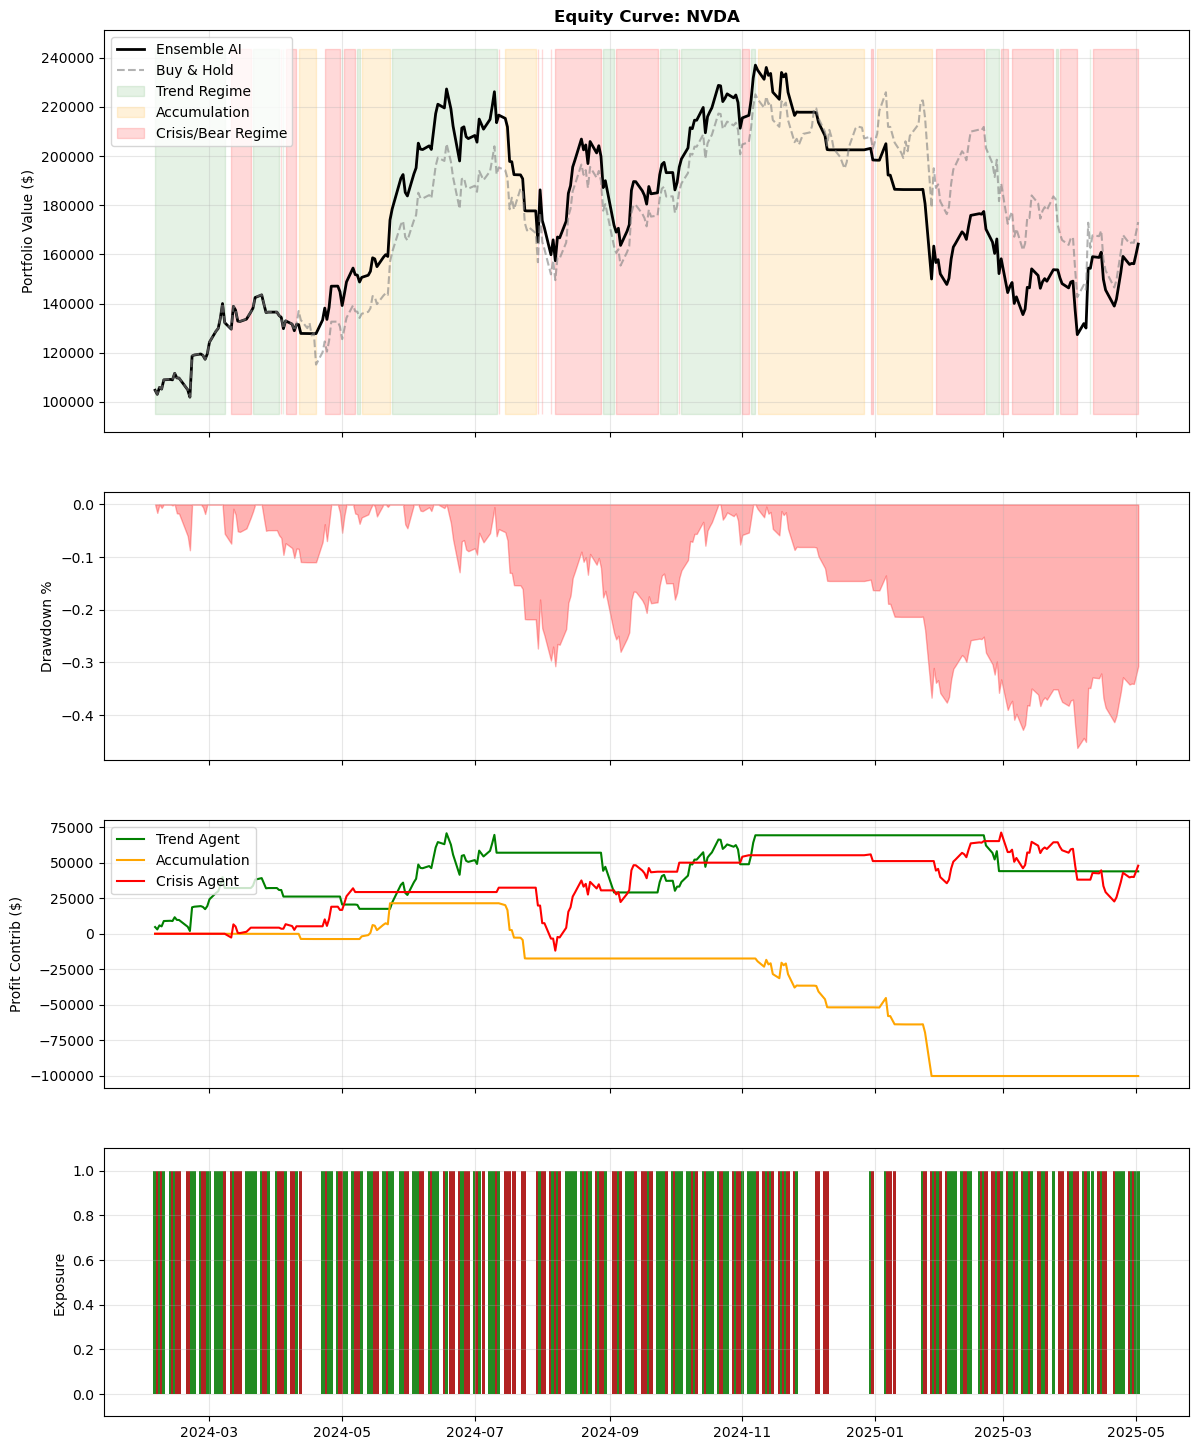

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
DEFAULT_CONFIG = {
    # Assets
    "TICKERS": ["SPY", "IWM", "^VIX", "SHY"], 
    "TARGET_ASSET": "SPY",
    
    # Dates
    "TRAIN_START": "2015-01-01",
    "TRAIN_END": "2023-12-31",
    "TEST_START": "2024-01-02",
    "TEST_END": "2025-05-05",
    
    # Crisis Training Periods
    "CRISIS_PERIODS": [
        ("2018-10-01", "2019-01-01"), # Volmageddon
        ("2020-01-01", "2020-05-01"), # COVID
        ("2022-01-01", "2022-12-31"), # Bear
    ],
    
    # Hyperparameters (Optimizable)
    "WINDOW_SIZE": 60, 
    "ADX_THRESHOLD": 25,
    "JUMP_THRESHOLD": 3.5, 
    "ACCUM_SMA_WINDOW": 50,
    "TARGET_VOL": 0.40,
    
    # Fixed Params
    "BB_STD": 2.0,
    "LEARNING_RATE": 3e-4,
    "BATCH_SIZE": 64,
    "TRAINING_STEPS": 50000, 
    "INITIAL_BALANCE": 100000,
    "FEES": 0.0005,
    "BORROW_RATE": 0.0002, 
    "ACTION_SCALER": 5.0,
    "MAX_LEVERAGE": 1.0, 
    "USE_VOL_TARGETING": True,
    "SMA_TREND_FILTER": True,
    "LONG_ONLY": False 
}

# --- DATA PROCESSOR ---
class DataProcessor:
    def __init__(self, tickers, config):
        self.tickers = list(set(tickers))
        self.config = config
        
    def download(self, start, end):
        try:
            if self.config['TARGET_ASSET'] not in self.tickers:
                self.tickers.append(self.config['TARGET_ASSET'])
                
            print(f"Fetching data for: {self.tickers} ({start} to {end})")
            data = yf.download(self.tickers, start=start, end=end, progress=False)
            
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]: data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]: data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]: data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): 
                data = data.to_frame()
                if self.config['TARGET_ASSET'] not in data.columns:
                    data.columns = [self.config['TARGET_ASSET']]
            
            # Need Volume for Volume Alpha
            ohlc = yf.download(self.config['TARGET_ASSET'], start=start, end=end, progress=False)
            
            # Merge Volume into main data if not present (simple check)
            if 'Volume' not in data.columns:
                data['Volume'] = ohlc['Volume']
                
            return data, ohlc
        except Exception as e:
            print(f"Data Download Error: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def calculate_lee_mykland(self, df, window=20):
        try:
            close = df['Close']
        except KeyError:
            close = df.iloc[:, 0] if isinstance(df, pd.DataFrame) else df
            
        log_ret = np.log(close / close.shift(1))
        abs_ret = np.abs(log_ret)
        bv_terms = abs_ret * abs_ret.shift(1)
        local_vol = np.sqrt((np.pi / 2) * bv_terms.rolling(window=window).mean())
        l_stat = log_ret / (local_vol + 1e-9)
        return l_stat.fillna(0)

    def calculate_vw_macd(self, df, fast=12, slow=26, signal=9):
        # Handle case where df is Series or DataFrame
        try:
            close = df['Close']
        except KeyError:
            close = df.iloc[:, 0] if isinstance(df, pd.DataFrame) else df

        try:
            volume = df['Volume']
        except KeyError:
            volume = 1.0 

        vw_price = close * volume
        ema_fast = vw_price.ewm(span=fast, adjust=False).mean()
        ema_slow = vw_price.ewm(span=slow, adjust=False).mean()
        vw_macd_line = ema_fast - ema_slow
        vw_signal_line = vw_macd_line.ewm(span=signal, adjust=False).mean()
        vw_hist = vw_macd_line - vw_signal_line
        return vw_hist.fillna(0)

    def calculate_force_index(self, df, window=13):
        try:
            close = df['Close']
        except KeyError:
            close = df.iloc[:, 0] if isinstance(df, pd.DataFrame) else df
            
        try:
            volume = df['Volume']
        except KeyError:
            volume = 1.0

        raw_force = (close - close.shift(1)) * volume
        efi = raw_force.ewm(span=window, adjust=False).mean()
        return efi.fillna(0)

    def add_features(self, df, ohlc):
        target = self.config['TARGET_ASSET']
        if df.empty or target not in df.columns: return pd.DataFrame()
        
        df = df.copy()
        
        # Ensure Volume Exists (Handle MultiIndex or Missing)
        if 'Volume' not in df.columns:
             try:
                 df['Volume'] = ohlc['Volume']
             except:
                 df['Volume'] = 1.0 

        df['returns'] = df[target].pct_change()
        
        # --- VOLUME ALPHA INDICATORS ---
        df['vw_macd_hist'] = self.calculate_vw_macd(df)
        df['efi_13'] = self.calculate_force_index(df)
        df['vol_avg_20'] = df['Volume'].rolling(window=20).mean()
        
        # JUMP DETECTION
        l_stat = self.calculate_lee_mykland(df, window=20)
        df['l_stat'] = l_stat
        
        # RSI 
        delta = df[target].diff()
        gain = (delta.where(delta > 0, 0)).fillna(0)
        loss = (-delta.where(delta < 0, 0)).fillna(0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # Trend
        high = ohlc['High']
        low = ohlc['Low']
        close = ohlc['Close']
        df['tr'] = np.maximum(high - low, np.maximum(abs(high - close.shift(1)), abs(low - close.shift(1))))
        df['dm_plus'] = np.where((high - high.shift(1)) > (low.shift(1) - low), np.maximum(high - high.shift(1), 0), 0)
        df['dm_minus'] = np.where((low.shift(1) - low) > (high - high.shift(1)), np.maximum(low.shift(1) - low, 0), 0)
        
        window = 14
        df['tr_s'] = df['tr'].rolling(window).mean()
        df['dp_s'] = df['dm_plus'].rolling(window).mean()
        df['dm_s'] = df['dm_minus'].rolling(window).mean()
        df['di_plus'] = 100 * (df['dp_s'] / df['tr_s'])
        df['di_minus'] = 100 * (df['dm_s'] / df['tr_s'])
        df['dx'] = 100 * abs(df['di_plus'] - df['di_minus']) / (df['di_plus'] + df['di_minus'])
        df['adx'] = df['dx'].rolling(window).mean()
        
        # Mean Reversion / Crisis
        sma = df[target].rolling(20).mean()
        std = df[target].rolling(20).std()
        df['bb_width'] = (std * 2 * 2) / sma
        df['pct_b'] = (df[target] - (sma - 2*std)) / (4*std)
        
        if '^VIX' in df.columns: df['vix_norm'] = (df['^VIX'] - 15) / 40
        else: df['vix_norm'] = 0
            
        sma200 = df[target].rolling(200).mean()
        df['dist_sma200'] = (df[target] - sma200) / sma200
        
        # --- DYNAMIC SMA GENERATION ---
        df['dist_sma50'] = (df[target] - df[target].rolling(50).mean()) / df[target].rolling(50).mean()
        df['dist_sma100'] = (df[target] - df[target].rolling(100).mean()) / df[target].rolling(100).mean()
        df['dist_sma150'] = (df[target] - df[target].rolling(150).mean()) / df[target].rolling(150).mean()
        df['dist_sma200'] = (df[target] - df[target].rolling(200).mean()) / df[target].rolling(200).mean()
        
        # Volatility
        df['realized_vol_20d'] = df['returns'].rolling(20).std() * np.sqrt(252)
        df['vol_percentile'] = df['realized_vol_20d'].rolling(252).rank(pct=True)
        
        return df.fillna(0)

    def get_data(self, start, end):
        df, ohlc = self.download(start, end)
        return self.add_features(df, ohlc)

    def get_crisis_data(self):
        dfs = []
        for s, e in self.config['CRISIS_PERIODS']:
            d, o = self.download(s, e)
            dfs.append(self.add_features(d, o))
        return pd.concat(dfs).reset_index(drop=True).fillna(0)

# --- ENVIRONMENT ---
class TradingEnv(gym.Env):
    def __init__(self, df, config, mode='trend'):
        super(TradingEnv, self).__init__()
        self.df = df
        self.config = config
        self.mode = mode 
        self.n_features = df.shape[1]
        self.window = config['WINDOW_SIZE']
        self.current_step = self.window
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window * self.n_features,), dtype=np.float32)
        
        self.data = df.values.astype(np.float32)
        self.cols = df.columns.tolist()
        self.idx_sma = self.cols.index('dist_sma200') if 'dist_sma200' in self.cols else -1
        self.idx_pct_b = self.cols.index('pct_b') if 'pct_b' in self.cols else -1
        
    def reset(self, seed=None, options=None):
        self.current_step = self.window
        return self._get_obs(), {}
    
    def _get_obs(self):
        return self.data[self.current_step-self.window : self.current_step].flatten()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            return self._get_obs(), 0, True, False, {}
            
        act = np.clip(action[0], -1, 1)
        ret = self.data[self.current_step, 0] 
        
        reward = 0
        if self.mode == 'trend':
            reward = act * ret * 100
            if self.idx_sma != -1:
                sma_dist = self.data[self.current_step, self.idx_sma]
                if sma_dist > 0 and act > 0.1: reward += 0.05 * act 
                elif sma_dist < 0 and act < -0.1: reward += 0.05 * abs(act)
                
        elif self.mode == 'accumulation': 
            reward = (act * ret * 100) 
            if act > 0.5: reward += 0.05 * act
            if act < 0: reward -= 0.1 * abs(act)

        elif self.mode == 'crisis':
            reward = (act * ret * 100)
            if ret < -0.01 and act < -0.1: reward *= 2.0 
            elif ret < -0.01 and act > 0.1: reward -= (act * 10.0) 
            
        elif self.mode == 'recovery': 
            reward = (act * ret * 100)
            if act > 0.5 and ret > 0.02: 
                reward *= 1.5 
            
        self.current_step += 1
        return self._get_obs(), reward, False, False, {}

# --- MANAGER ---
class EnsembleManager:
    def __init__(self, config):
        self.config = config
        self.dp = DataProcessor(config['TICKERS'], config)
        self.agents = {}
        self.envs = {}
        
    def train_specialists(self, verbose=True):
        if verbose: print("\n=== 1. TRAINING SPECIALIST AGENTS ===")
        trend_data = self.dp.get_data(self.config['TRAIN_START'], self.config['TRAIN_END'])
        
        # 1. Trend
        env_trend = DummyVecEnv([lambda: TradingEnv(trend_data, self.config, mode='trend')])
        env_trend = VecNormalize(env_trend, norm_obs=True, norm_reward=False)
        model_trend = PPO("MlpPolicy", env_trend, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_trend.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['trend'] = model_trend
        self.envs['trend'] = env_trend
        
        # 2. Accumulation
        env_acc = DummyVecEnv([lambda: TradingEnv(trend_data, self.config, mode='accumulation')]) 
        env_acc = VecNormalize(env_acc, norm_obs=True, norm_reward=False)
        model_acc = PPO("MlpPolicy", env_acc, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_acc.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['accumulation'] = model_acc
        self.envs['accumulation'] = env_acc
        
        # 3. Crisis
        crash_data = self.dp.get_crisis_data()
        env_crisis = DummyVecEnv([lambda: TradingEnv(crash_data, self.config, mode='crisis')])
        env_crisis = VecNormalize(env_crisis, norm_obs=True, norm_reward=False)
        model_crisis = PPO("MlpPolicy", env_crisis, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_crisis.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['crisis'] = model_crisis
        self.envs['crisis'] = env_crisis
        
        # 4. Recovery 
        env_rec = DummyVecEnv([lambda: TradingEnv(trend_data, self.config, mode='recovery')])
        env_rec = VecNormalize(env_rec, norm_obs=True, norm_reward=False)
        model_rec = PPO("MlpPolicy", env_rec, verbose=0, learning_rate=self.config['LEARNING_RATE'])
        model_rec.learn(total_timesteps=self.config['TRAINING_STEPS'])
        self.agents['recovery'] = model_rec
        self.envs['recovery'] = env_rec
        
        if verbose: print("=== TRAINING COMPLETE ===\n")

    def run_backtest(self, start_date=None, end_date=None, plot_results=True):
        s_date = start_date if start_date else self.config['TEST_START']
        e_date = end_date if end_date else self.config['TEST_END']
        
        if plot_results: print(f"=== 2. RUNNING BACKTEST ({s_date} to {e_date}) ===")
        
        warmup_dt = pd.Timestamp(s_date) - pd.Timedelta(days=365)
        full_data = self.dp.get_data(warmup_dt.strftime('%Y-%m-%d'), e_date)
        if full_data.empty: return 0.0
        
        test_indices = np.where((full_data.index >= s_date) & (full_data.index <= e_date))[0]
        if len(test_indices) == 0: return 0.0

        portfolio = self.config['INITIAL_BALANCE']
        benchmark_equity = self.config['INITIAL_BALANCE'] 
        holdings = 0
        history = []
        
        regime_stats = {
            'trend': {'days': 0, 'log_ret': 0.0, 'bench_log_ret': 0.0},
            'accumulation': {'days': 0, 'log_ret': 0.0, 'bench_log_ret': 0.0},
            'crisis': {'days': 0, 'log_ret': 0.0, 'bench_log_ret': 0.0},
            'recovery': {'days': 0, 'log_ret': 0.0, 'bench_log_ret': 0.0} 
        }
        
        cols = full_data.columns.tolist()
        idx_adx = cols.index('adx')
        idx_sma = cols.index('dist_sma200')
        idx_ret = cols.index('returns')
        idx_vol_pct = cols.index('vol_percentile')
        idx_raw_vol = cols.index('realized_vol_20d')
        idx_di_plus = cols.index('di_plus')
        idx_di_minus = cols.index('di_minus')
        idx_l_stat = cols.index('l_stat')
        idx_pct_b = cols.index('pct_b')
        idx_rsi = cols.index('rsi')
        idx_vol = cols.index('Volume')
        idx_vol_avg = cols.index('vol_avg_20')
        idx_efi = cols.index('efi_13')
        
        # --- SELECT DYNAMIC SMA FROM CONFIG ---
        safety_window = self.config['ACCUM_SMA_WINDOW']
        sma_col_name = f'dist_sma{safety_window}'
        idx_safety_sma = cols.index(sma_col_name) if sma_col_name in cols else idx_sma
        
        data_vals = full_data.values
        dates = full_data.index
        window = self.config['WINDOW_SIZE']
        
        agent_pnls = {'trend': 0.0, 'accumulation': 0.0, 'crisis': 0.0, 'recovery': 0.0}
        
        if plot_results:
            print(f"{'Date':<12} | {'Regime':<12} | {'Active Agent':<12} | {'Raw Act':<8} | {'Scale Act':<10} | {'Portfolio':<10} | {'Bench':<10} | {'Daily Alpha':<11}")
            print("-" * 120)
        
        is_accum_invested = True 
        
        for t in test_indices:
            obs_raw = data_vals[t-window : t].flatten()
            
            vol_pct = data_vals[t-1, idx_vol_pct] 
            raw_vol = data_vals[t-1, idx_raw_vol]
            adx = data_vals[t-1, idx_adx]
            sma_dist = data_vals[t-1, idx_sma]
            safety_sma_dist = data_vals[t-1, idx_safety_sma]
            rsi = data_vals[t-1, idx_rsi] 
            di_plus = data_vals[t-1, idx_di_plus]
            di_minus = data_vals[t-1, idx_di_minus]
            l_stat = data_vals[t-1, idx_l_stat]
            
            # --- VOLUME ALPHA SIGNALS (V14) ---
            curr_vol = data_vals[t-1, idx_vol]
            avg_vol = data_vals[t-1, idx_vol_avg]
            efi = data_vals[t-1, idx_efi]
            
            is_oversold = (rsi < 35) 
            is_volume_spike = (curr_vol > 1.5 * avg_vol) 
            
            is_recovery = is_oversold and is_volume_spike 
            
            # --- DYNAMIC THRESHOLDS ---
            JUMP_THRESH = self.config['JUMP_THRESHOLD']
            ADX_THRESH = self.config['ADX_THRESHOLD']
            
            is_bullish_jump = (l_stat > JUMP_THRESH)
            is_bearish_jump = (l_stat < -JUMP_THRESH)
            is_extreme_vol = (vol_pct > 0.90)
            is_crash = (sma_dist < -0.10)
            is_bull_trend = (adx > ADX_THRESH) and (di_plus > di_minus)
            is_bear_trend = (adx > ADX_THRESH) and (di_minus > di_plus)
            
            # PRIORITY LOGIC
            if is_recovery:
                regime, active_agent_name = "RECOVERY", "recovery"
            elif is_bearish_jump:
                regime, active_agent_name = "JUMP_BEAR", "crisis"
            elif is_bullish_jump:
                regime, active_agent_name = "JUMP_BULL", "trend"
            elif is_extreme_vol or is_crash: 
                regime, active_agent_name = "CRISIS", "crisis"
            elif is_bear_trend:
                regime, active_agent_name = "BEAR_TREND", "crisis"
            elif is_bull_trend: 
                regime, active_agent_name = "TREND", "trend"
            else:
                regime, active_agent_name = "ACCUMULATION", "accumulation"
                
            # Predict
            agent = self.agents[active_agent_name]
            norm_env = self.envs[active_agent_name]
            obs_norm = norm_env.normalize_obs(obs_raw)
            action, _ = agent.predict(obs_norm, deterministic=True)
            
            # Exec
            mkt_ret = data_vals[t, idx_ret]
            raw_action = action[0]
            
            # --- OVERRIDES ---
            
            if regime == 'RECOVERY':
                raw_action = 1.0 
            
            if regime == 'JUMP_BULL':
                raw_action = 1.0
            
            if active_agent_name == 'trend' and raw_action < 0:
                raw_action = 0.5 
                
            # --- ACCUMULATION WITH RSI + HYSTERESIS ---
            if active_agent_name == 'accumulation':
                if sma_dist > 0:
                    if safety_sma_dist > 0.02: is_accum_invested = True
                    elif safety_sma_dist < -0.02: is_accum_invested = False
                    
                    is_rsi_healthy = (rsi > 45)
                    
                    if is_accum_invested and is_rsi_healthy:
                        if raw_action > 0.2: raw_action = 1.0
                        elif raw_action > -0.5: raw_action = 0.5
                    else:
                        raw_action = 0.0 
            
            # Vol Targeting
            vol_scaler = 1.0
            if self.config['USE_VOL_TARGETING'] and raw_vol > 0.01:
                vol_scaler = self.config['TARGET_VOL'] / raw_vol
            vol_scaler = np.clip(vol_scaler, 0.1, 2.0)
            
            # --- DEFENSIVE OVERRIDE ---
            if self.config['LONG_ONLY']:
                if regime == 'RECOVERY':
                    scaled_action = 1.0 * self.config['ACTION_SCALER'] * vol_scaler 
                elif regime == 'JUMP_BEAR':
                    scaled_action = 0.0
                elif regime == 'BEAR_TREND':
                    if raw_action > 0.8: scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler 
                    elif raw_action > 0.5: scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler * 0.5 
                    else: scaled_action = 0.0
                elif regime == 'CRISIS':
                    scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler
                else:
                    scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler
            else:
                scaled_action = raw_action * self.config['ACTION_SCALER'] * vol_scaler

            if self.config['LONG_ONLY']: scaled_action = np.clip(scaled_action, 0, 10)
            
            if self.config['SMA_TREND_FILTER'] and active_agent_name == 'trend':
                if sma_dist < 0: scaled_action = np.clip(scaled_action, -10, 0)
                elif sma_dist > 0: scaled_action = np.clip(scaled_action, 0, 10)
            
            position_size = np.clip(scaled_action, -self.config['MAX_LEVERAGE'], self.config['MAX_LEVERAGE'])
            
            # PnL
            cost = abs(position_size - holdings) * self.config['FEES']
            lev_cost = max(0, abs(position_size)-1) * self.config['BORROW_RATE']
            
            step_pnl_pct = (position_size * mkt_ret) - cost - lev_cost
            step_pnl_dollars = portfolio * step_pnl_pct
            
            portfolio *= (1 + step_pnl_pct)
            benchmark_equity *= (1 + mkt_ret)
            holdings = position_size
            
            agent_pnls[active_agent_name] += step_pnl_dollars
            
            # Stats
            regime_stats[active_agent_name]['days'] += 1
            regime_stats[active_agent_name]['log_ret'] += np.log1p(step_pnl_pct)
            regime_stats[active_agent_name]['bench_log_ret'] += np.log1p(mkt_ret)
            
            alpha_bps = (step_pnl_pct - mkt_ret) * 10000
            
            if plot_results and t % 20 == 0: 
                print(f"{str(dates[t].date()):<12} | {regime:<12} | {active_agent_name:<12} | {raw_action:<8.2f} | {position_size:<10.2f} | {portfolio:<10.0f} | {benchmark_equity:<10.0f} | {alpha_bps:>8.0f} bps")
                
            history.append({
                'Date': dates[t],
                'Portfolio': portfolio,
                'Regime': regime,
                'Agent': active_agent_name,
                'Return': step_pnl_pct,
                'Benchmark': mkt_ret,
                'Scale Act': position_size,
                'Trend_PnL': agent_pnls['trend'],
                'MeanRev_PnL': agent_pnls['accumulation'],
                'Crisis_PnL': agent_pnls['crisis']
            })
            
        res = pd.DataFrame(history).set_index('Date')
        total_ret = (portfolio / self.config['INITIAL_BALANCE']) - 1
        
        if plot_results:
            bench_ret = (1 + res['Benchmark']).cumprod().iloc[-1] - 1
            print(f"\n=== FINAL REPORT: {total_ret:.2%} (Bench: {bench_ret:.2%}) ===")
            
            print("\n=== AGENT PERFORMANCE BREAKDOWN (vs Benchmark in same period) ===")
            print(f"{'Agent':<12} | {'Days':<6} | {'Agent Ret':<12} | {'Bench Ret':<12} | {'Alpha':<12}")
            print("-" * 65)
            for agent_name, stats in regime_stats.items():
                if stats['days'] > 0:
                    agent_ret = np.exp(stats['log_ret']) - 1
                    bench_ret = np.exp(stats['bench_log_ret']) - 1
                    alpha = agent_ret - bench_ret
                    print(f"{agent_name:<12} | {stats['days']:<6} | {agent_ret:>11.2%} | {bench_ret:>11.2%} | {alpha:>11.2%}")
                else:
                    print(f"{agent_name:<12} | {0:<6} | {'N/A':>11} | {'N/A':>11} | {'0.00%':>11}")
            print("-" * 65)
            
            self.plot_dashboard(res)
            
        return total_ret

    def plot_dashboard(self, res):
        fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 2, 2, 2]})
        plt.subplots_adjust(hspace=0.2)
        
        res['Bench_Equity'] = (1 + res['Benchmark']).cumprod() * self.config['INITIAL_BALANCE']
        ax0 = axes[0]
        ax0.plot(res.index, res['Portfolio'], label='Ensemble AI', color='black', linewidth=2)
        ax0.plot(res.index, res['Bench_Equity'], label='Buy & Hold', color='gray', linestyle='--', alpha=0.6)
        ax0.set_title(f"Equity Curve: {self.config['TARGET_ASSET']}", fontweight='bold')
        ax0.set_ylabel("Portfolio Value ($)")
        ax0.grid(True, alpha=0.3)
        
        y_min, y_max = ax0.get_ylim()
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'trend'), color='green', alpha=0.1, label='Trend Regime')
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'accumulation'), color='orange', alpha=0.15, label='Accumulation')
        ax0.fill_between(res.index, y_min, y_max, where=(res['Agent'] == 'crisis'), color='red', alpha=0.15, label='Crisis/Bear Regime')
        ax0.legend(loc='upper left', frameon=True)

        ax1 = axes[1]
        strat_peak = res['Portfolio'].cummax()
        strat_dd = (res['Portfolio'] - strat_peak) / strat_peak
        ax1.fill_between(res.index, strat_dd, 0, color='red', alpha=0.3, label='Strategy Drawdown')
        ax1.set_ylabel("Drawdown %")
        ax1.grid(True, alpha=0.3)

        ax2 = axes[2]
        ax2.plot(res.index, res['Trend_PnL'], label='Trend Agent', color='green', linewidth=1.5)
        ax2.plot(res.index, res['MeanRev_PnL'], label='Accumulation', color='orange', linewidth=1.5)
        ax2.plot(res.index, res['Crisis_PnL'], label='Crisis Agent', color='red', linewidth=1.5)
        ax2.set_ylabel("Profit Contrib ($)")
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        ax3 = axes[3]
        colors = ['forestgreen' if r > 0 else 'firebrick' for r in res['Return']]
        ax3.bar(res.index, res['Scale Act'], color=colors, width=1.5)
        ax3.set_ylabel("Exposure")
        ax3.set_ylim(-0.1, self.config['MAX_LEVERAGE']*1.1)
        ax3.grid(True, alpha=0.3)
        
        plt.show()

# --- HYPERPARAMETER OPTIMIZER ---
class HyperparameterOptimizer:
    def __init__(self, tickers, target):
        self.tickers = tickers
        self.target = target
        
    def optimize(self, train_start, train_end):
        print(f"\n>>> STARTING HYPERPARAMETER OPTIMIZATION FOR {self.target} <<<")
        print(">>> OPTIMIZATION MODE: SMART GRID (Train once per Window, Backtest many) <<<")
        
        # 1. Training Parameters (Requires Retraining PPO)
        training_grid = {
            "WINDOW_SIZE": [40, 60]
        }
        
        # 2. Inference Parameters (Instant Backtest - No Retraining)
        inference_grid = {
            "ADX_THRESHOLD": [15, 20, 25, 35, 45], 
            "JUMP_THRESHOLD": [2.0, 2.5, 3.5, 4.5],
            "ACCUM_SMA_WINDOW": [50, 100, 150, 200] 
        }
        
        best_ret = -np.inf
        best_config = {} # Initialize as empty dict
        
        # Outer Loop: Architecture (Slow)
        for window in training_grid["WINDOW_SIZE"]:
            print(f"\n[Training Phase] Compiling Agents for Window Size: {window}...")
            
            # Setup Base Config
            base_config = DEFAULT_CONFIG.copy()
            base_config['WINDOW_SIZE'] = window
            base_config['TICKERS'] = self.tickers
            base_config['TARGET_ASSET'] = self.target
            base_config['TRAIN_START'] = train_start
            base_config['TRAIN_END'] = train_end
            base_config['TRAINING_STEPS'] = 10000 
            
            # Train Agents ONCE for this Window Size
            # We pass a COPY to ensure base_config isn't polluted by the manager
            mgr = EnsembleManager(base_config.copy())
            mgr.train_specialists(verbose=False)
            
            # Inner Loop: Logic Thresholds (Fast)
            keys, values = zip(*inference_grid.items())
            combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
            
            print(f"[Inference Phase] Testing {len(combinations)} threshold combinations...")
            
            for i, params in enumerate(combinations):
                # Update Manager's Config in-place (No Retraining)
                mgr.config.update(params)
                
                # Set Validation Period (This modifies mgr.config, but not base_config now)
                mgr.config['TEST_START'] = str(int(train_end[:4]) - 1) + train_end[4:]
                mgr.config['TEST_END'] = train_end
                
                # Run Fast Backtest
                ret = mgr.run_backtest(plot_results=False)
                
                if ret > best_ret:
                    best_ret = ret
                    # BUG FIX: Construct a clean dictionary with ONLY the hyperparameters.
                    # Do NOT copy the full config to avoid carrying over validation dates.
                    best_config = {
                        "WINDOW_SIZE": window,
                        **params
                    }
                    print(f"  >>> NEW BEST: {ret:.2%} | Win:{window} | {params}")
                
        print(f"\n>>> BEST PARAMETERS FOUND: {best_config} (Ret: {best_ret:.2%}) <<<")
        return best_config

def run_system(tickers, target, start, end, optimize=True):
    config = DEFAULT_CONFIG.copy()
    config['TICKERS'] = tickers
    config['TARGET_ASSET'] = target
    config['TEST_START'] = start
    config['TEST_END'] = end
    
    # Safety Defaults for Single Stock
    if target != "SPY":
        config['LONG_ONLY'] = True
        config['MAX_LEVERAGE'] = 1.0
        config['TRAINING_STEPS'] = 50000 
        config['USE_VOL_TARGETING'] = False 
        config['ACTION_SCALER'] = 10.0 

    if optimize:
        opt = HyperparameterOptimizer(tickers, target)
        best_params = opt.optimize("2015-01-01", "2023-12-31") 
        config.update(best_params)
    
    print("\n>>> INITIALIZING TRINITY V15 (FINAL) <<<")
    print(f"Config: Window={config['WINDOW_SIZE']}, ADX={config['ADX_THRESHOLD']}, Jump={config['JUMP_THRESHOLD']}, AccumSMA={config['ACCUM_SMA_WINDOW']}")
    
    mgr = EnsembleManager(config)
    mgr.train_specialists()
    mgr.run_backtest()

if __name__ == "__main__":
    MY_TICKERS = ["NVDA", "^VIX", "SHY"]
    MY_TARGET = "NVDA"
    START = "2024-02-05" 
    END = "2025-05-05"

    run_system(MY_TICKERS, MY_TARGET, START, END, optimize=True)